In [1]:
import re

import io
from tqdm import tqdm

import pandas as pd
import numpy as np

import emoji

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.layers import TextVectorization

In [3]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [4]:
def load_glove(fname):
    embeddings_index = {}
    with open(fname, encoding="utf8") as f:
        for line in tqdm(f):
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    
    return embeddings_index

In [5]:
parameters = {}
parameters['embedding_name'] = './embeddings/glove.twitter.27B.100d.txt'
parameters['save_path'] = 'models/text_emotion_cnn_lstm/'

In [6]:
embedding_index = load_glove(parameters['embedding_name'])
print('Number of word vectors : ', len(embedding_index))

1193514it [00:49, 24301.85it/s]

Number of word vectors :  1193514


## Reading and Pre-processing

In [7]:
df = pd.read_csv('../Data/text_emotion.csv')

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                   "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [9]:
import codecs
import unidecode
import re
import spacy
nlp = spacy.load('en')

def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [10]:
def clean_text(data):
    data = (re.sub(r"(#[\d\w\.]+)", '', data)).lower()
    data = emoji.demojize(data)
    data = spacy_cleaner(data)
    return data

In [11]:
df['text'] = df['content'].apply(clean_text)

<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequence '\ '
  decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequence '\l'
  decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequence '\|'
  decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequence '\m'
  decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequence '\/'
  decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequence '\o'
  decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequenc

In [12]:
classes = sorted(list(set(df['sentiment'])))
no_classes = len(classes)

class_mapping = {}
for idx, name in enumerate(classes):
    class_mapping[name] = idx 

In [13]:
_ = df.pop('tweet_id')
_ = df.pop('author')

In [14]:
df['label'] = df['sentiment'].apply(lambda x : class_mapping[x])

In [15]:
def build_dataset(df, feature='text', target='label'):
    dataset = (
                tf.data.Dataset.from_tensor_slices(
                    (
                        tf.cast(df[feature].values, tf.string),
                        tf.cast(df[target].values, tf.int32)
                    )
                )
            )
    return dataset

In [16]:
df_train, df_test = train_test_split(df, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.2)

train_dataset = build_dataset(df_train)
val_dataset = build_dataset(df_val)
test_dataset = build_dataset(df_test)

In [17]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

In [18]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=100)
vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [20]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'be', 'to', 'the']

In [21]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [22]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 16369 words (3389 misses)


In [23]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [24]:
x_train = vectorizer(np.array([[s] for s in list(df_train.text)])).numpy()
x_val = vectorizer(np.array([[s] for s in list(df_val.text)])).numpy()

y_train = np.array(list(df_train.label))
y_val = np.array(list(df_val.label))

In [25]:
import os
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [26]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class CustomCallback(Callback):
    def __init__(self, validation_data=None):
        super(CustomCallback, self).__init__()
        self.validation_data = validation_data
        
    def on_train_begin(self, logs={}):        
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs={}):        
        val_predict = (np.asarray(self.model.predict(self.validation_data[0])))
        val_predict = [np.argmax(i) for i in val_predict]
        
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average = 'weighted')
        _val_recall = recall_score(val_targ, val_predict, average = 'weighted')
        _val_precision = precision_score(val_targ, val_predict, average = 'weighted')
        
        print("— val_f1: %f — val_precision: %f — val_recall %f"%(_val_f1, _val_precision, _val_recall))
        
        if _val_f1 > self.best_f1:
            make_dir(parameters['save_path'])
            self.model.save_weights(f"{parameters['save_path']}")
            self.best_f1 = _val_f1
            
            print("saving...")
        
        return

In [27]:
from tensorflow.keras import layers
import tensorflow_addons as tfa

metric_f1 = tfa.metrics.F1Score(num_classes=4, threshold=0.5, average = 'weighted')

int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
embedded_sequences.trainable = False 

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedded_sequences)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)

x = layers.Conv1D(128, 2, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(128, 2, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(128, 2, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

preds = layers.Dense(no_classes, activation="softmax")(x)

model = tf.keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         1976000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         32896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         32896 

In [28]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                    batch_size = 128, epochs = 10, shuffle = True, 
                    callbacks = [CustomCallback(validation_data = (x_val, y_val))])

Epoch 1/10
200/200 [==============================] - 142s 688ms/step - loss: 2.1288 - accuracy: 0.2652 - val_loss: 1.9649 - val_accuracy: 0.3286


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


— val_f1: 0.258731 — val_precision: 0.224347 — val_recall 0.328594
saving...
Epoch 2/10
200/200 [==============================] - 131s 654ms/step - loss: 1.9558 - accuracy: 0.3337 - val_loss: 1.9105 - val_accuracy: 0.3459


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


— val_f1: 0.281817 — val_precision: 0.277850 — val_recall 0.345938
saving...
Epoch 3/10
200/200 [==============================] - 130s 653ms/step - loss: 1.9093 - accuracy: 0.3577 - val_loss: 1.9160 - val_accuracy: 0.3444


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


— val_f1: 0.276667 — val_precision: 0.286082 — val_recall 0.344375
Epoch 4/10
200/200 [==============================] - 138s 689ms/step - loss: 1.8822 - accuracy: 0.3651 - val_loss: 1.8753 - val_accuracy: 0.3534


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


— val_f1: 0.298061 — val_precision: 0.284080 — val_recall 0.353438
saving...
Epoch 5/10
200/200 [==============================] - 139s 695ms/step - loss: 1.8555 - accuracy: 0.3698 - val_loss: 1.8861 - val_accuracy: 0.3539


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


— val_f1: 0.298254 — val_precision: 0.319896 — val_recall 0.353906
saving...
Epoch 6/10
200/200 [==============================] - 138s 691ms/step - loss: 1.8379 - accuracy: 0.3767 - val_loss: 1.8808 - val_accuracy: 0.3567


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


— val_f1: 0.303699 — val_precision: 0.305376 — val_recall 0.356719
saving...
Epoch 7/10
200/200 [==============================] - 136s 680ms/step - loss: 1.8082 - accuracy: 0.3867 - val_loss: 1.8725 - val_accuracy: 0.3600


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


— val_f1: 0.312000 — val_precision: 0.297983 — val_recall 0.360000
saving...
Epoch 8/10
200/200 [==============================] - 138s 691ms/step - loss: 1.7916 - accuracy: 0.3939 - val_loss: 1.8755 - val_accuracy: 0.3619


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


— val_f1: 0.319696 — val_precision: 0.298003 — val_recall 0.361875
saving...
Epoch 9/10
200/200 [==============================] - 145s 727ms/step - loss: 1.7650 - accuracy: 0.4030 - val_loss: 1.8890 - val_accuracy: 0.3597


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


— val_f1: 0.320110 — val_precision: 0.292708 — val_recall 0.359687
saving...
Epoch 10/10
200/200 [==============================] - 140s 699ms/step - loss: 1.7411 - accuracy: 0.4091 - val_loss: 1.8913 - val_accuracy: 0.3606
— val_f1: 0.314381 — val_precision: 0.308275 — val_recall 0.360625


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


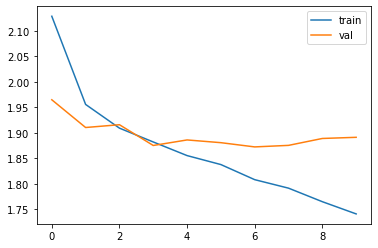

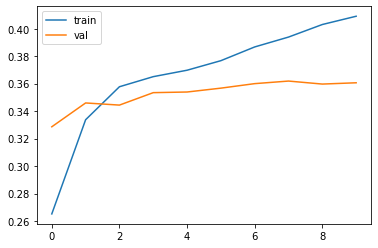

In [29]:
plt.figure(1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

## Comparing Model Performance on Test Data

In [30]:
model.load_weights(parameters['save_path'])

In [31]:
x_test = vectorizer(np.array([[s] for s in list(df_test.text)])).numpy()
y_test = np.array(list(df_test.label))

In [32]:
model.evaluate(x_test, y_test)

250/250 [==============================] - 13s 46ms/step - loss: 1.8866 - accuracy: 0.3619


[1.8865656852722168, 0.3618749976158142]

In [33]:
pred = model.predict(x_test)

pred_idx = []

for i in tqdm(range(len(pred))):
    pred_idx.append(np.argmax(pred[i]))

100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 347818.85it/s]


In [34]:
print(classification_report(y_test, pred_idx, target_names=classes))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        25
     boredom       0.00      0.00      0.00        36
       empty       0.00      0.00      0.00       179
  enthusiasm       0.00      0.00      0.00       144
         fun       0.00      0.00      0.00       383
   happiness       0.32      0.48      0.38      1031
        hate       0.32      0.24      0.27       255
        love       0.42      0.44      0.43       759
     neutral       0.39      0.54      0.45      1731
      relief       0.00      0.00      0.00       301
     sadness       0.35      0.31      0.33      1038
    surprise       0.00      0.00      0.00       432
       worry       0.35      0.45      0.40      1686

    accuracy                           0.36      8000
   macro avg       0.17      0.19      0.17      8000
weighted avg       0.29      0.36      0.32      8000



C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


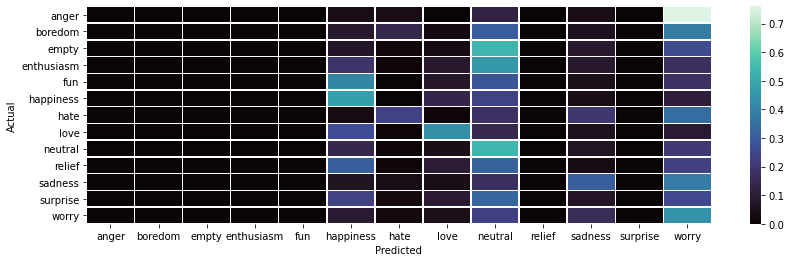

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(y_test, pred_idx)
# Normalise
cmn = cm.astype('float')
fig, ax = plt.subplots(figsize=(14,4))
sns.heatmap(cmn/cm.sum(axis=1)[:, np.newaxis], fmt='.2f', xticklabels=classes, yticklabels=classes, cmap="mako", linewidths=.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()